# Selecting Obvious Migdals for New Dataset

- Objective is to remove from the dataset events which don't really look like Migdal events but are actually Migdal.
- Reasons for this uncertainty could be that the electron is going into the page, riding on top of the nuclear recoil etc.
- The idea is not to train the model to learn that events that don't look like Migdal are actually Migdal (by training on the new dataset) since this will confuse the model learning.
- By training on the new dataset, false positives will be reduces (accuracy may go down, but low false positives is more important for the context of the experiment).


How
- Train original model as previously
- Make cut and select images/events which are actually Migdal but (by being above cut) are classified by the model as being not Migdal
- These (false negative) events are hence likely to be not obvious to identify (since the model is not certain).
- Adjust cut until there is an appropriate number of false negatives to be removed (and still have a large enough dataset).
- Remove these events from the dataset and re-train a new model on the reduced dataset.

In [1]:
import numpy as np
from skimage import io
from os import listdir
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

2022-09-02 17:40:57.930320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### GPU testing

In [2]:
with tf.device('/GPU:0'):

    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-09-02 17:40:59.285125: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-02 17:40:59.286693: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-02 17:40:59.779010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 17:40:59.779299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:03.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-09-02 17:40:59.779341: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-02 17:40:59.781316: I tensorflow/stream_executor/platform/default/ds

### Loading Model

In [3]:
from tensorflow.keras.models import load_model
model = load_model("tl_mod_1.h5")

### Loading Data

In [6]:
file_type_list = ['_0.0_threshold', '_0.0_threshold', '_4.0_threshold']
sqrt_scale = [0,1,0]

im_stack_plain = np.stack([np.sqrt(np.load('np_data/NR_noise'+f+'.npy')) if s \
                           else np.load('np_data/NR_noise'+f+'.npy') \
                           for f,s in zip(file_type_list,sqrt_scale)],axis=-1)

im_stack = np.stack([np.sqrt(np.load('np_data/Migdal_noise'+f+'.npy')) if s \
                           else np.load('np_data/Migdal_noise'+f+'.npy') \
                           for f,s in zip(file_type_list,sqrt_scale)],axis=-1)

e_stack = np.stack([np.sqrt(np.load('np_data/Electron_noise'+f+'.npy')) if s \
                           else np.load('np_data/Electron_noise'+f+'.npy') \
                           for f,s in zip(file_type_list,sqrt_scale)],axis=-1)

not_mig = np.concatenate([im_stack_plain,e_stack])

labels = np.concatenate([np.zeros_like(im_stack[:,0,0,0]),np.ones_like(not_mig[:,0,0,0])])
data = np.concatenate([im_stack,not_mig])

del im_stack_plain, im_stack, e_stack, not_mig

In [7]:
pred_list = [model(np.expand_dims(x, axis=0)).numpy().flatten() for x in data]

2022-08-04 10:19:35.851491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-04 10:19:40.004014: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [8]:
np.shape(pred_list)

(29517, 1)

In [9]:
pred_list

[array([0.00117595], dtype=float32),
 array([0.00433863], dtype=float32),
 array([1.368557e-05], dtype=float32),
 array([0.28592488], dtype=float32),
 array([4.1855955e-07], dtype=float32),
 array([0.12679623], dtype=float32),
 array([9.595234e-06], dtype=float32),
 array([0.00028524], dtype=float32),
 array([7.354925e-05], dtype=float32),
 array([0.00293479], dtype=float32),
 array([0.4565537], dtype=float32),
 array([0.04001747], dtype=float32),
 array([0.00089653], dtype=float32),
 array([3.464859e-05], dtype=float32),
 array([0.41638693], dtype=float32),
 array([0.06152242], dtype=float32),
 array([2.9451214e-05], dtype=float32),
 array([0.1324731], dtype=float32),
 array([0.02625581], dtype=float32),
 array([0.00164113], dtype=float32),
 array([9.273426e-05], dtype=float32),
 array([0.0613899], dtype=float32),
 array([0.05889173], dtype=float32),
 array([0.2812196], dtype=float32),
 array([0.00030746], dtype=float32),
 array([0.0075073], dtype=float32),
 array([0.00321118], dtype=

# ROC Curve Before Obvious Training

In [4]:
from tensorflow.keras.models import load_model
model = load_model("tl_mod_1.h5")

In [5]:
def data_func_stack(file_type_list,sqrt_scale):
    
    im_stack_plain = np.stack([np.sqrt(np.load('np_data/NR_noise'+f+'.npy')) if s \
                               else np.load('np_data/NR_noise'+f+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
    
    im_stack = np.stack([np.sqrt(np.load('np_data/Migdal_noise'+f+'.npy')) if s \
                               else np.load('np_data/Migdal_noise'+f+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
    
    e_stack = np.stack([np.sqrt(np.load('np_data/Electron_noise'+f+'.npy')) if s \
                               else np.load('np_data/Electron_noise'+f+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
    
    not_mig = np.concatenate([im_stack_plain,e_stack])
    
    shuffle_index = np.arange(len(not_mig))
    np.random.shuffle(shuffle_index)

    not_mig_shuff = not_mig[shuffle_index]
    new_not_mig = not_mig_shuff[:len(im_stack)]
    
    labels = np.concatenate([np.zeros_like(im_stack[:,0,0,0]),np.ones_like(new_not_mig[:,0,0,0])])
    data = np.concatenate([im_stack,new_not_mig])

    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)

    labels = labels[shuffle_index]
    data = data[shuffle_index]

    del im_stack_plain, im_stack, e_stack, not_mig, not_mig_shuff, new_not_mig, shuffle_index
    
    #loading the data into tf.data.Dataset objects
    total_dataset_noise = tf.data.Dataset.from_tensor_slices((data, labels)) 

    #batching the datasets
    batch_size = 50
    total_dataset_noise = total_dataset_noise.batch(batch_size)  # drop_remainder=True
    
    del data, labels
    
    return total_dataset_noise

In [6]:
file_type_list = ['_0.0_threshold', '_0.0_threshold', '_4.0_threshold']
sqrt_scale = [0,1,0]
total_dataset_noise = data_func_stack(file_type_list, sqrt_scale)

actual_label = []
fp_indices = []
migdals = 0

cut = 0.01
total = 0

for tdn in total_dataset_noise:
    data, labels = tdn
    labels = labels.numpy().flatten()
    batch_probs = model(data).numpy().flatten()
    indices = np.where(batch_probs < cut)[0] #+ counter
    actual_label.extend(list(labels[indices]))
    migdals += len(labels[labels == 0])

    fp_indices.extend(list(np.where((batch_probs < cut) & (labels == 1))[0] + total))

    total += len(labels)

test_list = [x for x in actual_label if x == 0]
del data, labels, batch_probs, indices
print()
print(f'Number of Migdal events identified with cut of {cut} = {len(actual_label)}')
print(f'Accuracy with cut of {cut} = {(len(test_list)/len(actual_label)*100):.3f}%')
print('Total number of images tested: '+str(total))
print('Total number of actual Migdal events tested: '+str(migdals))
print('Number of Migdal events identified: '+str(len(actual_label)))
# print('Number of Migdal events missed: '+str(len([x for x in test_labels if x == 0])-len(test_list)))
print(f'Percentage of Migdal events identified correctly: {(100*len(test_list)/migdals):.3f}%')
print('Number of false positive Migdal events: '+str(len(actual_label)-len(test_list)))
print(f'False-positive rate: {(100*(len(actual_label)-len(test_list))/(total-migdals)):.3g}%')
print()

fpr, acc = (100*(len(actual_label)-len(test_list))/(total-migdals)), (100*len(test_list)/migdals)

2022-09-02 17:45:16.280291: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10572120000 exceeds 10% of free system memory.
2022-09-02 17:45:20.081132: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10572120000 exceeds 10% of free system memory.
2022-09-02 17:45:22.780373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-02 17:45:26.688538: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10



Number of Migdal events identified with cut of 0.01 = 5687
Accuracy with cut of 0.01 = 99.982%
Total number of images tested: 19578
Total number of actual Migdal events tested: 9789
Number of Migdal events identified: 5687
Percentage of Migdal events identified correctly: 58.086%
Number of false positive Migdal events: 1
False-positive rate: 0.0102%



In [7]:
from sklearn.metrics import roc_curve

y_pred_keras = []
labels_tot = []

for tdn in total_dataset_noise:
    data, labels = tdn
    y_pred_keras.extend(1-model(data))
    labels_tot.extend(1-labels)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_tot, y_pred_keras)

2022-09-02 17:45:37.511577: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10572120000 exceeds 10% of free system memory.


In [8]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

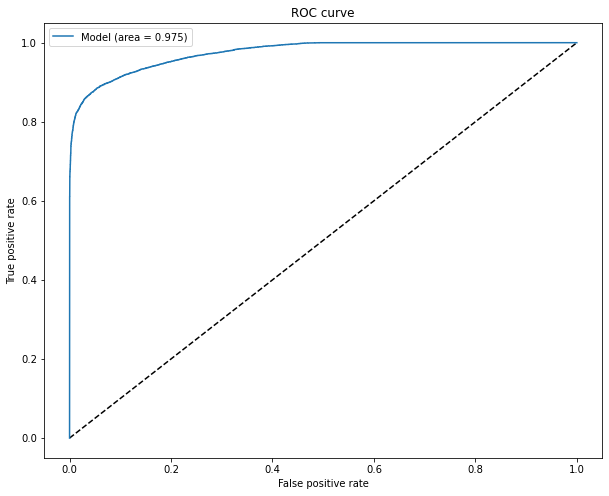

In [9]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

I'm trying to remove Migdal events which don't look like Migdal events/there is uncertainty.

So:

Define cut (closer to 0). 0 = Migdal, 1 = Not Migdal \
Find events which are greater than cut but actually are Migdal. (i.e. classified as not Migdal but actually Migdal) \
Imshow these events to see what they look like.

Add indices of events to new list (so that they can be inspected and later removed).

In [10]:
cut = 0.01
false_neg_ind = []

for i in np.arange(len(data)):
    if pred_list[i] > cut and labels[i] < cut:
        false_neg_ind.append(i)
        
print("Number of false negatives with cut of "+str(cut)+": "+str(np.size(false_neg_ind)))
print("Percentage of dataset to be removed: "+str((np.size(false_neg_ind))*100/len(data)))

Number of false negatives with cut of 0.01: 4103
Percentage of dataset to be removed: 13.90046413930955


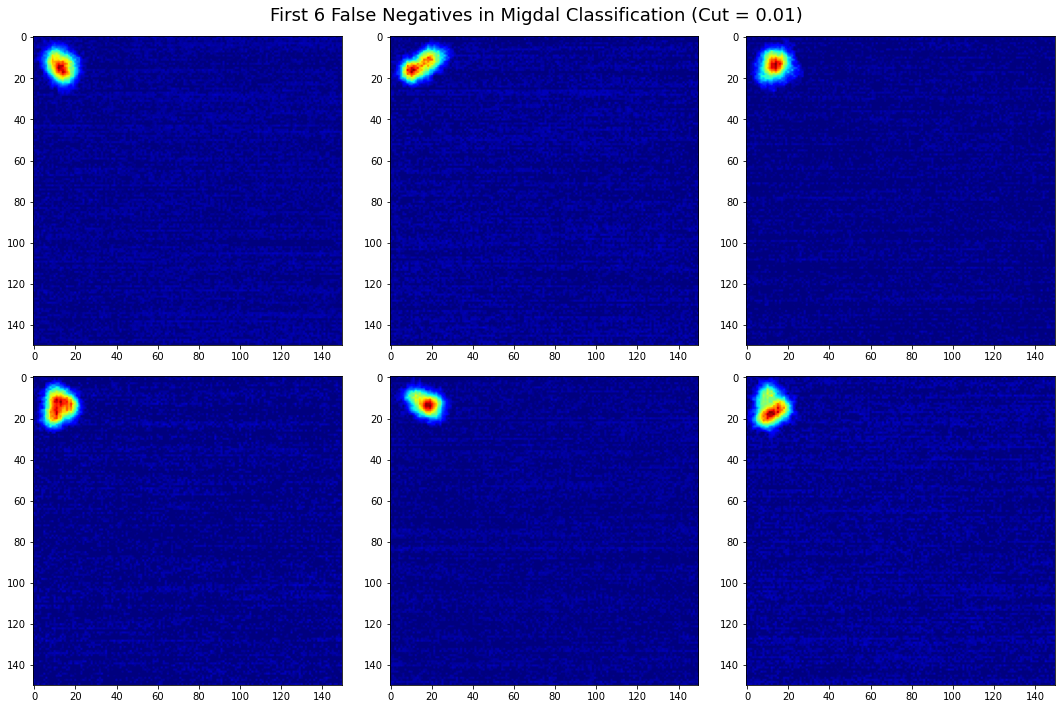

In [11]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle(f'First 6 False Negatives in Migdal Classification (Cut = {cut})',fontsize=18)
fig.subplots_adjust(top=0.96)
fig.tight_layout()
ax1.imshow(data[false_neg_ind[0]][:,:,1],cmap='jet')
ax2.imshow(data[false_neg_ind[1]][:,:,1],cmap='jet')
ax3.imshow(data[false_neg_ind[2]][:,:,1],cmap='jet')
ax4.imshow(data[false_neg_ind[3]][:,:,1],cmap='jet')
ax5.imshow(data[false_neg_ind[4]][:,:,1],cmap='jet')
ax6.imshow(data[false_neg_ind[5]][:,:,1],cmap='jet');

In [18]:
false_neg_ind = np.asarray(false_neg_ind)

arr_truth = np.ones(len(data),dtype=bool)
arr_truth[false_neg_ind] = False

In [19]:
data_new = data[arr_truth]

print(np.shape(data_new))
print(np.shape(data))

(25414, 150, 150, 3)
(29517, 150, 150, 3)


In [20]:
labels_new = labels[arr_truth]

print(np.shape(labels_new))
print(np.shape(labels))

(25414,)
(29517,)


In [21]:
np.save(f'obvious_data/data_with_cut_{cut}.npy',data_new)
np.save(f'obvious_data/labels_with_cut_{cut}.npy',labels_new)

# Training on obvious Migdal data

In [18]:
data = np.load('obvious_data/data_with_cut_0.01.npy')
labels = np.load('obvious_data/labels_with_cut_0.01.npy')

In [19]:
shuffle_index = np.arange(len(data))
np.random.shuffle(shuffle_index)

data_shuff = data[shuffle_index]
labels_shuff = labels[shuffle_index]

train_data_noise, test_data_noise, train_labels, test_labels = \
train_test_split(data_shuff, labels_shuff, test_size=0.2, random_state=42)

del data, labels, shuffle_index, data_shuff, labels_shuff

#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((train_data_noise, train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((test_data_noise, test_labels))
# migdal_dataset_noise = tf.data.Dataset.from_tensor_slices((im_stack, np.zeros_like(energies)))
train_dataset_noise.element_spec

#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)
# migdal_dataset_noise = migdal_dataset_noise.batch(batch_size)

del train_data_noise, test_data_noise, train_labels, test_labels

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def opt_model():
    global file_type_list
    opt_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,len(file_type_list)), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.05),
        Dense(20, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
        LeakyReLU(),
        Dropout(0.05),
        Dense(10, kernel_regularizer = tf.keras.regularizers.L1L2(0.05,0.1)),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='opt_model')
    return opt_model

model = opt_model

In [9]:
file_type_list = ['_0.0_threshold', '_0.0_threshold', '_4.0_threshold']

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=15)

model = opt_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=150, validation_data=(test_dataset_noise),callbacks=[callback],\
         verbose = 1)

2022-08-04 10:45:10.488368: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10978740000 exceeds 10% of free system memory.
2022-08-04 10:45:13.172709: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10978740000 exceeds 10% of free system memory.


Epoch 1/150


2022-08-04 10:45:16.206877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-04 10:45:16.210158: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099995000 Hz
2022-08-04 10:45:16.392396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-04 10:45:16.971692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


407/407 [==============================] - 20s 37ms/step - loss: 26.6750 - accuracy: 0.8373 - val_loss: 3.5405 - val_accuracy: 0.8894


2022-08-04 10:45:35.592249: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10978740000 exceeds 10% of free system memory.


Epoch 2/150
407/407 [==============================] - 14s 34ms/step - loss: 3.1935 - accuracy: 0.8869 - val_loss: 2.1063 - val_accuracy: 0.9333


2022-08-04 10:45:52.261543: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10978740000 exceeds 10% of free system memory.


Epoch 3/150
407/407 [==============================] - 14s 34ms/step - loss: 1.9424 - accuracy: 0.9297 - val_loss: 1.4503 - val_accuracy: 0.9573
Epoch 4/150
407/407 [==============================] - 14s 34ms/step - loss: 1.4291 - accuracy: 0.9484 - val_loss: 1.2444 - val_accuracy: 0.9648
Epoch 5/150
407/407 [==============================] - 14s 34ms/step - loss: 1.2654 - accuracy: 0.9580 - val_loss: 1.1801 - val_accuracy: 0.9756
Epoch 6/150
407/407 [==============================] - 14s 34ms/step - loss: 1.2239 - accuracy: 0.9617 - val_loss: 1.1947 - val_accuracy: 0.9715
Epoch 7/150
407/407 [==============================] - 14s 34ms/step - loss: 1.2032 - accuracy: 0.9675 - val_loss: 1.1715 - val_accuracy: 0.9778
Epoch 8/150
407/407 [==============================] - 14s 34ms/step - loss: 1.2018 - accuracy: 0.9678 - val_loss: 1.1501 - val_accuracy: 0.9849
Epoch 9/150
407/407 [==============================] - 14s 35ms/step - loss: 1.1949 - accuracy: 0.9734 - val_loss: 1.1568 - val_ac

In [24]:
model.save('omdc_mod_1.h5')

In [26]:
def data_func_stack(file_type_list,sqrt_scale):
    
    im_stack_plain = np.stack([np.sqrt(np.load('np_data/NR_noise'+f+'.npy')) if s \
                               else np.load('np_data/NR_noise'+f+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
    
    im_stack = np.stack([np.sqrt(np.load('np_data/Migdal_noise'+f+'.npy')) if s \
                               else np.load('np_data/Migdal_noise'+f+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
    
    e_stack = np.stack([np.sqrt(np.load('np_data/Electron_noise'+f+'.npy')) if s \
                               else np.load('np_data/Electron_noise'+f+'.npy') \
                               for f,s in zip(file_type_list,sqrt_scale)],axis=-1)
    
    not_mig = np.concatenate([im_stack_plain,e_stack])
    
    shuffle_index = np.arange(len(not_mig))
    np.random.shuffle(shuffle_index)

    not_mig_shuff = not_mig[shuffle_index]
    new_not_mig = not_mig_shuff[:len(im_stack)]
    
    labels = np.concatenate([np.zeros_like(im_stack[:,0,0,0]),np.ones_like(new_not_mig[:,0,0,0])])
    data = np.concatenate([im_stack,new_not_mig])

    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)

    labels = labels[shuffle_index]
    data = data[shuffle_index]

    del im_stack_plain, im_stack, e_stack, not_mig, not_mig_shuff, new_not_mig, shuffle_index
    
    #loading the data into tf.data.Dataset objects
    total_dataset_noise = tf.data.Dataset.from_tensor_slices((data, labels)) 

    #batching the datasets
    batch_size = 50
    total_dataset_noise = total_dataset_noise.batch(batch_size)  # drop_remainder=True
    
    del data, labels
    
    return total_dataset_noise

In [31]:
file_type_list = ['_0.0_threshold', '_0.0_threshold', '_4.0_threshold']
sqrt_scale = [0,1,0]
total_dataset_noise = data_func_stack(file_type_list, sqrt_scale)

actual_label = []
fp_indices = []
migdals = 0

cut = 0.01
total = 0

for tdn in total_dataset_noise:
    data, labels = tdn
    labels = labels.numpy().flatten()
    batch_probs = model(data).numpy().flatten()
    indices = np.where(batch_probs < cut)[0] #+ counter
    actual_label.extend(list(labels[indices]))
    migdals += len(labels[labels == 0])

    fp_indices.extend(list(np.where((batch_probs < cut) & (labels == 1))[0] + total))

    total += len(labels)

test_list = [x for x in actual_label if x == 0]
del data, labels, batch_probs, indices
print()
print(f'Number of Migdal events identified with cut of {cut} = {len(actual_label)}')
print(f'Accuracy with cut of {cut} = {(len(test_list)/len(actual_label)*100):.3f}%')
print('Total number of images tested: '+str(total))
print('Total number of actual Migdal events tested: '+str(migdals))
print('Number of Migdal events identified: '+str(len(actual_label)))
# print('Number of Migdal events missed: '+str(len([x for x in test_labels if x == 0])-len(test_list)))
print(f'Percentage of Migdal events identified correctly: {(100*len(test_list)/migdals):.3f}%')
print('Number of false positive Migdal events: '+str(len(actual_label)-len(test_list)))
print(f'False-positive rate: {(100*(len(actual_label)-len(test_list))/(total-migdals)):.3g}%')
print()

fpr, acc = (100*(len(actual_label)-len(test_list))/(total-migdals)), (100*len(test_list)/migdals)


Number of Migdal events identified with cut of 0.01 = 5012
Accuracy with cut of 0.01 = 100.000%
Total number of images tested: 19578
Total number of actual Migdal events tested: 9789
Number of Migdal events identified: 5012
Percentage of Migdal events identified correctly: 51.200%
Number of false positive Migdal events: 0
False-positive rate: 0%



Calculating 90% confidence limit for false positive rate

Use 2.3 because single sided

In [32]:
2.44*100/(total-migdals)

0.024925937276534887

Assuming 30 migdals per million nuclear recoils, we would expect to correctly identify 15 of them using the above. And we would expect to have the following number of false positives (nuclear recoils misclassified as migdals).

In [4]:
(0.024925937276534887/100) * 10e6

2492.5937276534887

In [5]:
2492.5937276534887 / 15

166.17291517689924

So, 166 nuclear recoils for every migdal

### Summary

- Removed events which were classified as not Migdal but actually Migdal from dataset (with a cut). These are the 'not obvious events' as can be seen from the above figure (they all look like nuclear recoils). 
- Trained on this new dataset, achieved 99.72% accuracy.
- Reloaded entire original dataset (including not obvious migdals) and tested model predictions on that. Obviously this isn't ideal since the model has trained on some of this data. Calculated false positive rate and 90% confidence limit.

Next:
Test on unseen data. Try to use new data generated by Tim (including obvious Migdals etc.)

## ROC Curve

In [59]:
from sklearn.metrics import roc_curve

y_pred_keras = []
labels_tot = []

for tdn in total_dataset_noise:
    data, labels = tdn
    y_pred_keras.extend(1-model(data))
    labels_tot.extend(1-labels)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels_tot, y_pred_keras)

In [60]:
np.shape(labels_tot)

(19578,)

In [61]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

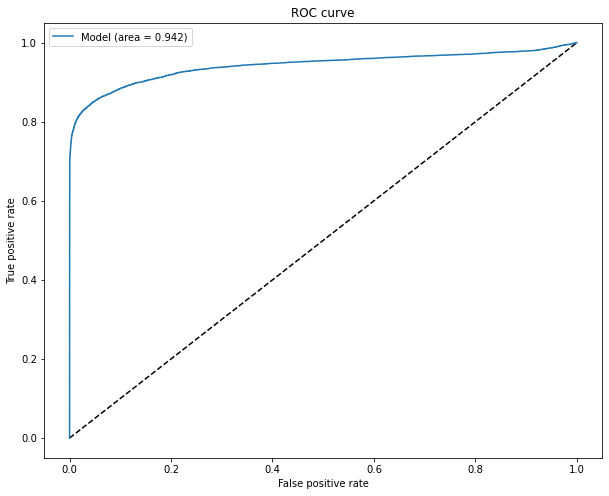

In [62]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [6]:
len(list1)

327